In [162]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from librosa import lpc
from scipy.io import wavfile
import sounddevice as sd
from scipy.signal import freqz

#### 1

##### 1.1

In [163]:
# function to synthetis an autoregressive (AR) process of length N, defined by its AR coefficients and the innovation variance σ2 .
def AR(N, coefs, sigma2):
    Z = np.random.normal(0, np.sqrt(sigma2), N)
    X = np.zeros(N)
    for i in range(N):
        X[i] = Z[i]
        for j in range(len(coefs)):
            X[i] += coefs[j] * X[i-j-1]
    return X

##### 1.2 Non-parametric estimation : periodogram

Code a function that computes and displays the periodogram of a given input signal, allowing to
choose between the standard method and the Bartlett and Welsh methods.

In [164]:
def periodogram(X, Bartlett = False, L = 1):
    N = len(X)
    if(Bartlett):
        # Bartlett method
        freq = np.fft.fftfreq(N)
        periodogram_values = []

        # Parameters
        M = int(np.sqrt(N))
        K = int(M /2)
        S = int( 2 * N / M)

        # Window
        window = np.bartlett(M)
        P = np.sum(window**2) / M   #Power of the window

        for mu in range(N):
            periodogram_r = 0
            for i in range(S):
                periodogram_ = np.fft.fft(X[i*K : i*K + M]*window, n= N)
                periodogram_r += np.abs(periodogram_[mu]) ** 2
            periodogram_values += [periodogram_r]
            
        periodogram_values = periodogram_values / (S*M*P)

        # remove negative frequencies
        periodogram_values = periodogram_values[freq >= 0]
        freq = freq[freq >= 0]

    else:
        # periodogram 
        periodogram_values = np.abs(np.fft.fft(X))**2 / N
        freq = np.fft.fftfreq(N)
        # remove negative frequencies
        periodogram_values = periodogram_values[freq >= 0]
        freq = freq[freq >= 0]
    plt.plot(freq, periodogram_values)
    plt.xlabel('Frequency')
    plt.ylabel('Periodogram')
    if (Bartlett):
        plt.title('Periodogram with Bartlett method')
    else:
        plt.title('Periodogram')
    plt.show()
    return freq, periodogram_values

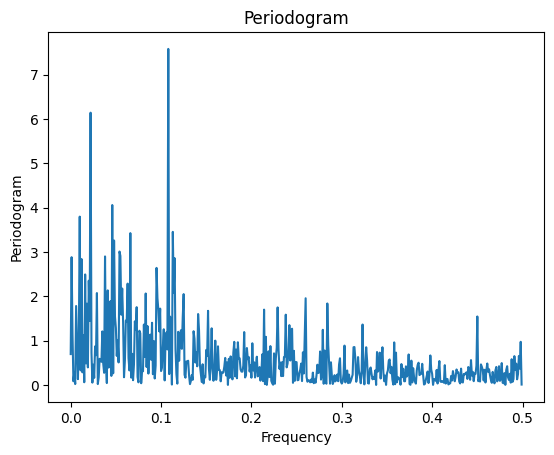

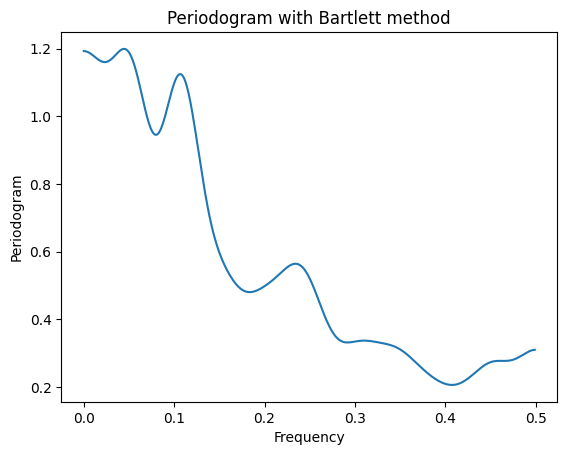

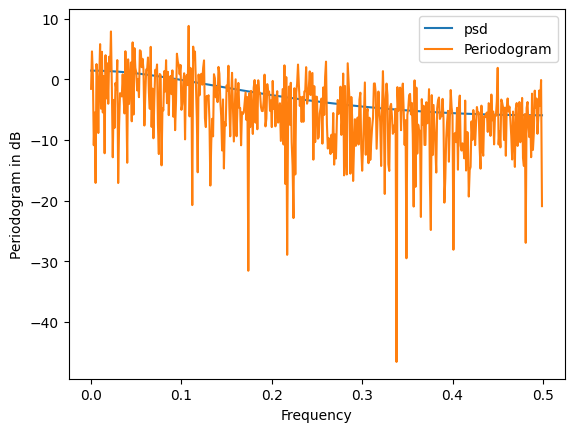

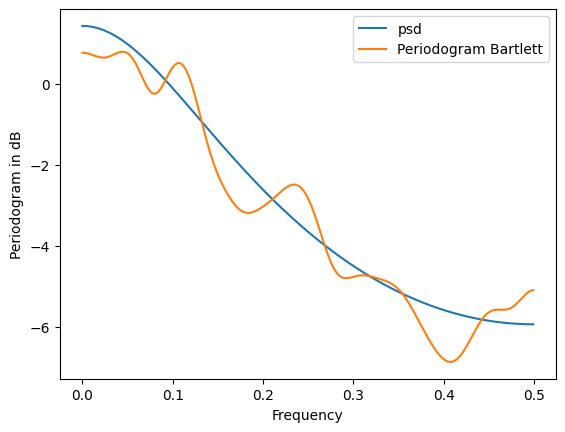

In [165]:
## AR process of order 1, length 100, with coefficients -0.2, and innovation variance 0.5
N = 1000
coefs = [0.4]
sigma2 = 0.5
X = AR(N, coefs, sigma2)

# periodogram of the AR process
freq1, per1 = periodogram(X)

# using Bartlett method
freq2, per2 = periodogram(X, Bartlett = True, L = 10)

# turn in to dB
per1 = 10 * np.log10(per1)
per2 = 10 * np.log10(per2)

# theorical PSD 
theoritical_psd = sigma2 / ( np.abs(1 - coefs[0] * np.exp(-2j*np.pi* freq1))**2)
theoritical_psd = 10 * np.log10(theoritical_psd)

plt.plot(freq1, theoritical_psd, label = 'psd')
plt.plot(freq2, per1, label = 'Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Periodogram in dB')
plt.legend()
plt.show()


plt.plot(freq1, theoritical_psd, label = 'psd')
plt.plot(freq2, per2, label = 'Periodogram Bartlett')
plt.xlabel('Frequency')
plt.ylabel('Periodogram in dB')
plt.legend()
plt.show()

1.2.4 Experimentaly compare these different estimators in terms of bias and variance.

In [174]:
print(f"The bias of the estimator is {np.mean(theoritical_psd - per1)}")

The bias of the estimator is 2.639072252260067 


##### 1.3 Parametric estimation : linear prediction

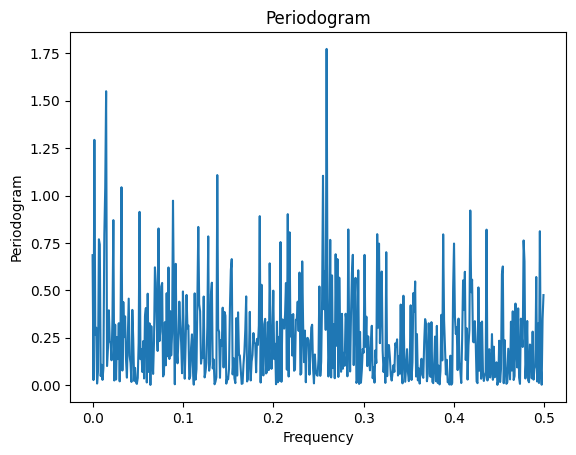

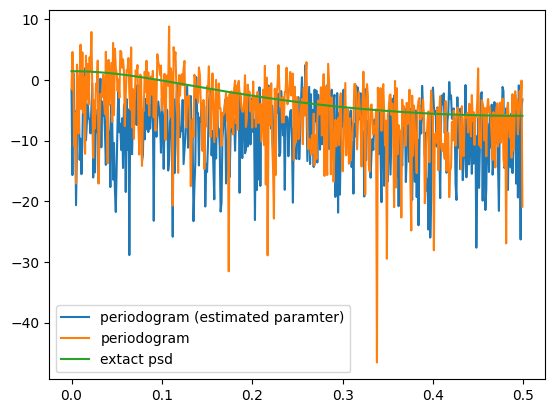

In [197]:
lpcoefs = lpc(X, order = 1)

X = AR(1000, [-1 * lpcoefs[1]], sigma2)

freqs, env = periodogram(X)
env = 10 * np.log10(env)

plt.plot(freqs, env, label = "periodogram (estimated paramter)")
plt.plot(freq1, per1, label = "periodogram")
plt.plot(freq1, theoritical_psd, label = "extact psd")
plt.legend()
plt.show()


#### 2. Sum of noisy sinusoids

##### 2.1 Synthesis

In [199]:
def sinusoids(N, K, freqs, ampls, originphi, sigma2):
    """
    function that synthesizes a signal of length N, consisting of the sum of K real sinusoids
    defined by their frequencies, amplitudes and origin phases, and a Gaussian white noise of variance σ2.         
    """
    wn = np.random.normal(0, np.sqrt(sigma2), N)
    sin = wn
    T = np.linspace(0, 100, N)
    for i in range(K):
        sin += ampls[i] * np.sin(2*np.pi * freqs[i] * T + originphi[i])
    
    return sin

##### 2.2 Non parametric estimation : periodogram 

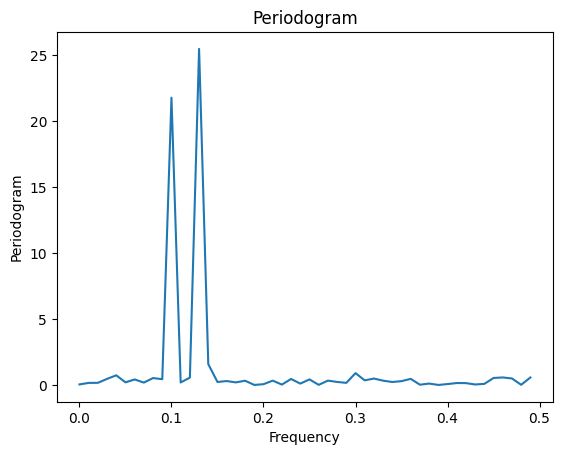

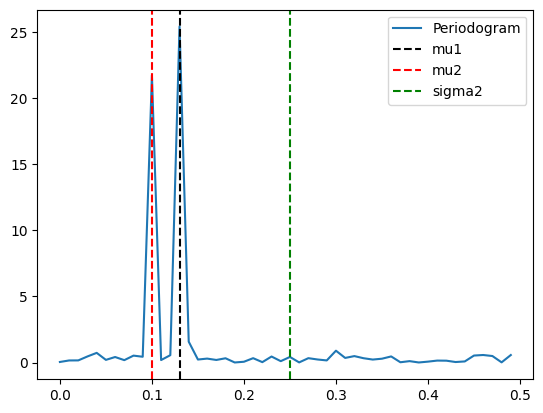

In [203]:
# signal synthesis
mu1, mu2 = 0.13, 0.1
sigma2 = 0.25
N = 100
signal = sinusoids(N, K = 2, freqs=[mu1, mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

freq_sinus, period_sinus = periodogram(signal)

plt.plot(freq_sinus, period_sinus, label = "Periodogram")
plt.axvline(mu1, color="black", linestyle="--", label = "mu1")
plt.axvline(mu2, color="red", linestyle="--", label = "mu2")
plt.axvline(sigma2, color="green", linestyle="--", label = "sigma2")
plt.legend()
plt.show()

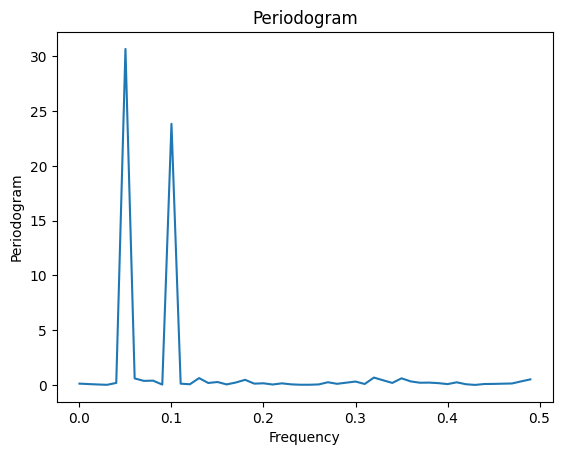

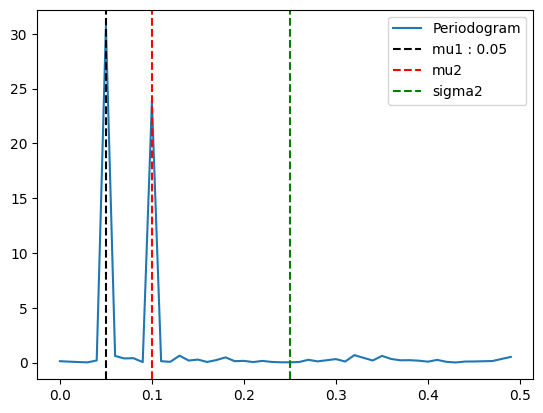

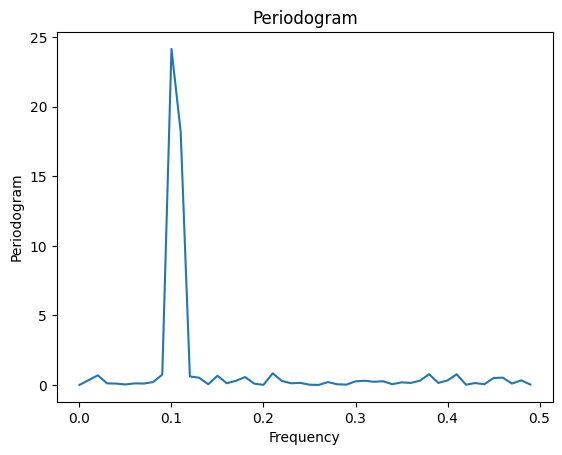

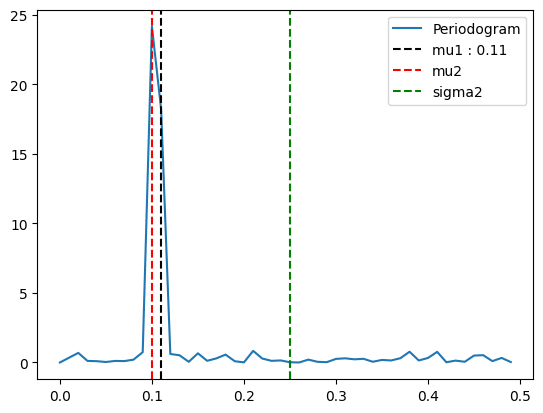

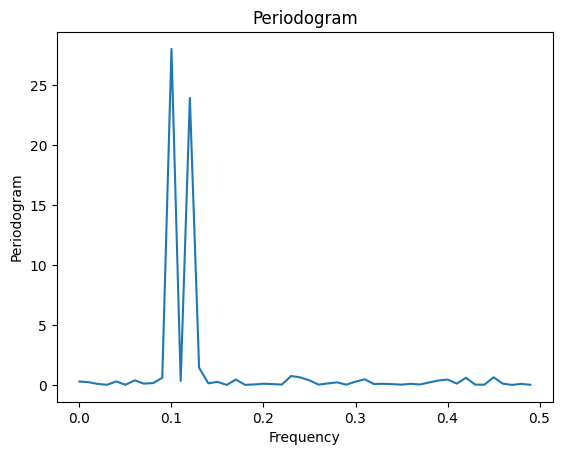

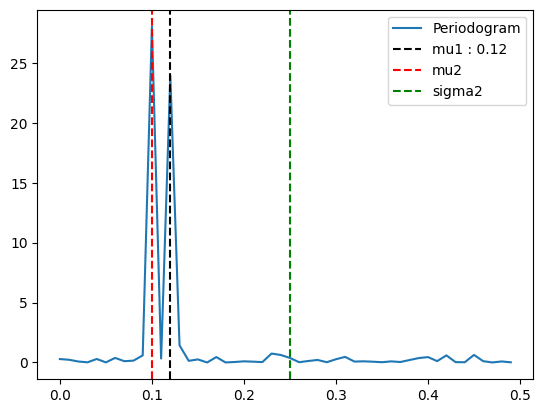

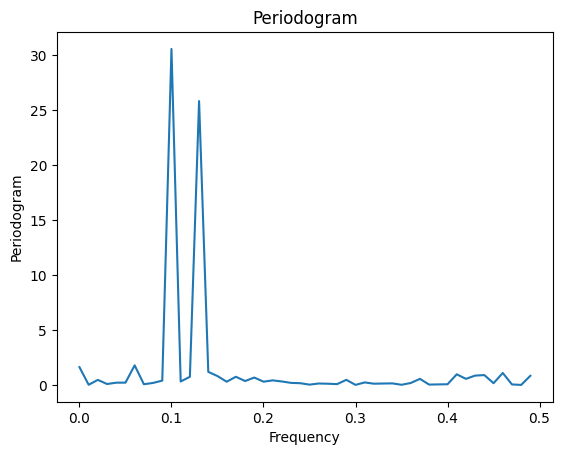

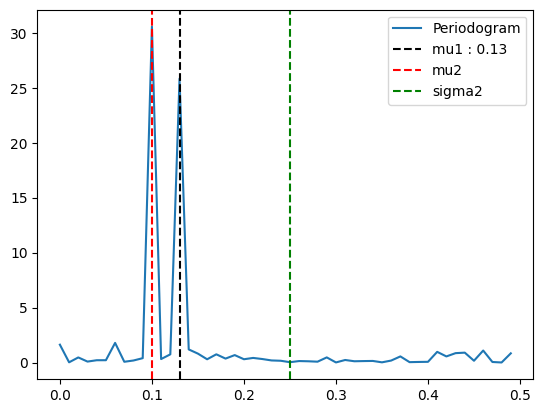

In [208]:
mu1 = [0.05, 0.11, 0.12, 0.13]
mu2 = 0.1

for i in range(4):
    signal = sinusoids(N, K = 2, freqs=[mu1[i], mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

    freq_sinus, period_sinus = periodogram(signal)

    plt.plot(freq_sinus, period_sinus, label = "Periodogram")
    plt.axvline(mu1[i], color="black", linestyle="--", label = f"mu1 : { mu1[i]}")
    plt.axvline(mu2, color="red", linestyle="--", label = "mu2")
    plt.axvline(sigma2, color="green", linestyle="--", label = "sigma2")
    plt.legend()
    plt.show()